In [1]:
# import sys
# !{sys.executable} -m pip install --user packagename

In [2]:
import os
import sys
import time
import warnings
from random import shuffle

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
import keras
from keras import backend as K
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate, Flatten, Dense
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model
from keras.models import load_model
from keras.models import model_from_json
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
import keras_metrics
from keras import layers
from keras import models

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# This is generator class to process data in batches and send them for training
class Surface_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, test=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    # return the total number of batches i.e. total_files/batch_size
    def __len__(self):
        return(int(np.ceil(float(len(self.image_filenames))/self.batch_size)))

    # this function is called for every mini-batch to get the images/masks for that mini-batch
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_arr = []
        mask_arr = []
        
        for file in batch_x:
            image = cv2.imread(file, 0)
            image = resize(image, (224, 224, 1))
            image_arr.append(image)
          
        for file in batch_y:
            image = cv2.imread(file, 0)
            image = resize(image, (224, 224, 1))
            mask_arr.append(image)

        return np.array(image_arr).astype(np.float32), np.array(mask_arr).astype(np.float32)
    
    # this function should return all the labels in the dataset
    def get_all_masks(self):
        mask_arr = []
        
        for file in self.labels:
            image = cv2.imread(file, 0)
            image = resize(image, (224, 224, 1))
            mask_arr.append(image)
        return np.array(mask_arr).astype(np.float32)

In [4]:
# Dice Coefficient metric
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Coefficient loss
def dice_coef_loss(y_true, y_pred):
    # YOUR CODE HERE
    return (1-dice_coef(y_true,y_pred))

In [5]:
## U-Net Model

# 2D convolution block
# This block contains two layers. 
# Each layer will be a Convolution operation followed by batch normalization with relu activation 
def conv2d_block(input_tensor, n_filters, kernel_size):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet_model(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((224, 224, 1))
    
    # contracting path
    c1 = conv2d_block(input_img,n_filters,kernel_size)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)
    p1 = Dropout(0.5*dropout_prob)(p1)

    c2 = conv2d_block(p1,2*n_filters,kernel_size)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)
    p2 = Dropout(dropout_prob)(p2)

    c3 = conv2d_block(p2,4*n_filters,kernel_size)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)
    p3 = Dropout(dropout_prob)(p3)

    c4 = conv2d_block(p3,8*n_filters,kernel_size)
    p4 = MaxPooling2D(pool_size=(2,2))(c4)
    p4 = Dropout(dropout_prob)(p4)

    # This is the layer where contractive and expansive paths combine
    c5 = conv2d_block(p4,16*n_filters,kernel_size)

    # Expansive path

    u6 = Conv2DTranspose(filters = 8*n_filters,kernel_size= kernel_size,strides=(2,2),padding='same')(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(dropout_prob)(u6)
    c6 = conv2d_block(u6,8*n_filters,kernel_size)
    
    u7 = Conv2DTranspose(filters = 4*n_filters,kernel_size= kernel_size,strides=(2,2),padding='same')(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout_prob)(u7)
    c7 = conv2d_block(u7,4*n_filters,kernel_size)
    
    u8 = Conv2DTranspose(filters = 2*n_filters,kernel_size= kernel_size,strides=(2,2),padding='same')(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout_prob)(u8)
    c8 = conv2d_block(u8,2*n_filters,kernel_size)

    u9 = Conv2DTranspose(filters = n_filters,kernel_size= kernel_size,strides=(2,2),padding='same')(c8)
    u9 = concatenate([u9,c1], axis = 3)
    u9 = Dropout(dropout_prob)(u9)
    c9 = conv2d_block(u9,n_filters,kernel_size)

    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [6]:
model_name = "unet"
model = get_unet_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
batch_size = 8
num_epochs = 40
# Compile the model
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])

In [8]:
# Set all the required Paths
xtrainPath = './InputDS/CVPPP2017_LCC_training/final/train_frames/train/'
xvalPath = './InputDS/CVPPP2017_LCC_training/final/val_frames/val/'
ytrainPath = './InputDS/CVPPP2017_LCC_training/final/train_masks/train/'
yvalPath = './InputDS/CVPPP2017_LCC_training/final/val_masks/val/'

X_train = []
y_train = []
X_val = []
y_val = []

listOfFiles = os.listdir(xtrainPath)
for entry in listOfFiles:
    X_train.append(xtrainPath + entry)
listOfFiles = os.listdir(xvalPath)
for entry in listOfFiles:
    X_val.append(xvalPath + entry)
listOfFiles = os.listdir(ytrainPath)
for entry in listOfFiles:
    y_train.append(ytrainPath + entry)
listOfFiles = os.listdir(yvalPath)
for entry in listOfFiles:
    y_val.append(yvalPath + entry)

# Create generator objects for training and validation
num_training_samples = len(X_train)
num_validation_samples = len(X_val)

training_batch_generator = Surface_Generator(X_train, y_train, batch_size, test=False)
validation_batch_generator = Surface_Generator(X_val, y_val, batch_size, test=False)

In [9]:
# Fit model
# stmillis = int(round(time.time() * 1000))
history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size))
# endmillis = int(round(time.time() * 1000))
# print("Time taken: ", endmillis - stmillis)

Epoch 1/40
85/85 [==============================] - 848s 10s/step - loss: 0.3018 - dice_coef: 0.6982 - val_loss: 0.7414 - val_dice_coef: 0.2586
Epoch 2/40
85/85 [==============================] - 1368s 16s/step - loss: 0.1368 - dice_coef: 0.8632 - val_loss: 0.6893 - val_dice_coef: 0.3107
Epoch 3/40
85/85 [==============================] - 1245s 15s/step - loss: 0.1222 - dice_coef: 0.8778 - val_loss: 0.9995 - val_dice_coef: 4.9964e-04
Epoch 4/40
85/85 [==============================] - 1260s 15s/step - loss: 0.1129 - dice_coef: 0.8871 - val_loss: 0.4290 - val_dice_coef: 0.5710
Epoch 5/40
85/85 [==============================] - 1342s 16s/step - loss: 0.0952 - dice_coef: 0.9048 - val_loss: 0.8761 - val_dice_coef: 0.1239
Epoch 6/40
85/85 [==============================] - 1207s 14s/step - loss: 0.0732 - dice_coef: 0.9268 - val_loss: 0.9999 - val_dice_coef: 6.1575e-05
Epoch 7/40
85/85 [==============================] - 1287s 15s/step - loss: 0.0767 - dice_coef: 0.9233 - val_loss: 0.2940 - 

In [8]:
# Save the trained weights
model.save('./model/_' + str(num_epochs) + '_' + model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open('./model/_' + str(num_epochs) + '_' + model_name + ".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
## Hyperparameter tuning
batches = [8, 16, 32]
kernels = [2, 3, 5]
num_epochs = 40
for batch_size in batches:
    for kernel_size in kernels:
        model_name = "unet"
        model = get_unet_model(kernel_size)
        model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])
        history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size))
        # Save the models
        model.save('./model/_' + str(num_epochs) + '_' + model_name + '_batch_size' + batch_size + '_kernel_size' + kernel_size + ".h5")
        # Save model config as json
        model_json = model.to_json()
        with open('./model/_' + str(num_epochs) + '_' + model_name + '_batch_size' + batch_size + '_kernel_size' + kernel_size + ".json", "w") as json_file:
            json_file.write(model_json)

In [9]:
## Loading the model
model = load_model('./model/_40_unet.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [10]:
import gc
gc.collect()

# Load test data in X_test and y_test
# YOUR CODE HERE
xtestPath = './InputDS/CVPPP2017_LCC_training/final_test/test_frames/test/'
ytestPath = './InputDS/CVPPP2017_LCC_training/final_test/test_masks/test/'
X_test = []
y_test = []

listOfFiles = os.listdir(xtestPath)
for entry in listOfFiles:
    X_test.append(xtestPath + entry)
listOfFiles = os.listdir(ytestPath)
for entry in listOfFiles:
    y_test.append(ytestPath + entry)
    
# print(X_test)
# print(y_test)
X_test = np.array(X_test)
y_test = np.array(y_test)
# X_test, y_test = ...

In [11]:
# for i in range(len(y_train)):
#     image = resize(cv2.imread(y_train[i], 0), (224, 224))
# #     image = cv2.resize(y_pred[i], (224, 224))
# #     print(image.shape)
#     plt.imshow(image, cmap='gray')
#     plt.show()

In [12]:
# Predict using model.predict_generator().
# YOUR CODE HERE
test_data_generator = Surface_Generator(X_test, y_test, batch_size, test=True)
y_pred = model.predict_generator(test_data_generator)

In [13]:
# y_true will have the true masks
y_true = test_data_generator.get_all_masks()
# print(X_test[20])
# print(y_true.shape)
# print(y_pred.shape)
print ("Dice coefficient on test data: ", K.get_value(dice_coef(y_true, y_pred)))

Dice coefficient on test data:  0.9698409


In [36]:
# print(y_test)

In [14]:
# Convert sigmoid outputs to binary class labels
y_pred[25][y_pred[25] >= 0.5] = 1
y_pred[25][y_pred[25] < 0.5] = 0

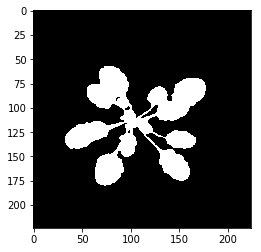

In [15]:
import matplotlib.pyplot as plt
plt.imshow(y_true[25][:,:,0], cmap='gray')
plt.show()

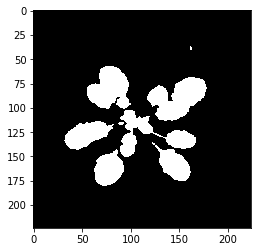

In [16]:
plt.imshow(y_pred[25][:,:,0], cmap='gray')
plt.show()

In [25]:
# Dice coefficient on this example
K.get_value(dice_coef(y_true[20], y_pred[20]))

0.96743935

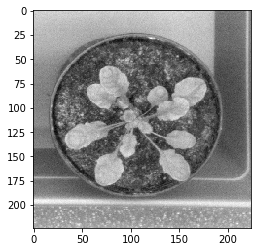

In [40]:
image = resize(cv2.imread(X_test[25], 0), (224, 224))
plt.imshow(image, cmap='gray')
plt.show()

In [13]:
# Before fitting the model, need to get all the train labels in trainY
train_df = pd.read_csv('./InputDS/CVPPP2017_LCC_training/Train_PlantCounts.csv')
val_df = pd.read_csv('./InputDS/CVPPP2017_LCC_training/Val_PlantCounts.csv')
test_df = pd.read_csv('./InputDS/CVPPP2017_LCC_training/Test_PlantCounts.csv')

In [14]:
### Now get both the plant fg images and the labels in the same order in 2 different numpy arrays
# count_values --> represents the numpy array containing the values of the counts for the train dataset
# image_fg_masks --> contains the numpy array containing the train image fg masks
count_value = []
img_fg_mask = []
for filepath in y_train:
    path, filename = os.path.split(filepath)
    count_value.append([train_df[train_df['Plant'] == filename]['Count'].item()])
    image = cv2.imread(filepath, 0)
    image = resize(image, (224, 224, 1))
    img_fg_mask.append(image)
### Convert both lists to numpy arrays
image_fg_masks = np.array(img_fg_mask)
count_values = np.array(count_value)

In [15]:
### Also create the validation data
count_val_value = []
img_fg_val_mask = []
for filepath in y_val:
    path, filename = os.path.split(filepath)
    count_val_value.append([val_df[val_df['Plant'] == filename]['Count'].item()])
    image = cv2.imread(filepath, 0)
    image = resize(image, (224, 224, 1))
    img_fg_val_mask.append(image)
### Convert both lists to numpy arrays
image_fg_val_masks = np.array(img_fg_val_mask)
count_val_values = np.array(count_val_value)

In [16]:
## Now printing both the arrays
# print(np.rank(image_fg_masks))
# print(count_values.shape)
# print(len(count_value))

In [17]:
## Now building the model for the purpose of making the count predictions
def get_cnn_reg_model(inputShape, filters=(64, 128, 256)):
    # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    chanDim = -1
    # model input
    inputs = Input(shape=inputShape)
 
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        if i == 0:
            x = inputs
            
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # applying another FC layer
    x = Dense(16)(x)
    x = Activation("relu")(x)
 
    #  regression node for the output
    x = Dense(1, activation="linear")(x)
 
    model = Model(inputs, x)
 
    # return the CNN model
    return model

In [18]:
inputShape = (224,224,1)
filters = (16, 32, 64)
model_f_name = "vgg"
model_f = get_cnn_reg_model(inputShape, filters)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_f.compile(loss="mse", optimizer=opt)

In [16]:
# Applying Data Augumentation to each FG image and storing it (creating 683*600 images by augmentation)
inPath = './InputDS/CVPPP2017_LCC_training/final/train_masks/train/'
outPath = './InputDS/CVPPP2017_LCC_training/augmented_fg_masks/'
listOfFiles = os.listdir(inPath) 
datagen = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.15, zoom_range = 0.1, channel_shift_range = 10., horizontal_flip = True, vertical_flip = True)
for entry in listOfFiles: 
    inputPath = inPath + entry
    filenumber = entry.split('.')[0]
    outputPath = outPath + str(filenumber) + '/'
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    i = 1
    fg_image = load_img(inputPath, target_size=(224, 224))
    x = img_to_array(fg_image)  
    x = x.reshape((1,) + x.shape)  
    for batch in datagen.flow(x, batch_size=1, save_to_dir=outputPath, save_format='png'):
        i += 1
        if i > 100:
            break

In [15]:
## Create empty dataframe
columns = ['Plant', 'Count']
allmasks_df = pd.DataFrame(columns=columns)
## Paths
inPath = './InputDS/CVPPP2017_LCC_training/augmented_fg_masks/'
outPath = './InputDS/CVPPP2017_LCC_training/augmented_final_fg_masks/'
## Moving the augmented images to new path
listOfFiles = os.listdir(inPath) 
for entry in listOfFiles:
    subInPath = inPath + entry + '/'
    subcounter = 1
    sublistOfFiles = os.listdir(subInPath)
    for image_entry in sublistOfFiles:
        img = load_img(subInPath+image_entry, target_size=(224, 224))
        img_array = img_to_array(img)
        save_img(outPath + entry + '_' + str(subcounter) + '.png', img_array)
        allmasks_df = allmasks_df.append({'Plant': entry + '_' + str(subcounter) + '.png', 'Count' : train_df[train_df['Plant'] == entry + '.png']['Count'].item()}, ignore_index = True)
        subcounter += 1

In [16]:
# Now transfer all the original images with their respective augumented images. This creates 1001 images in total for each original rgb image
inPath = './InputDS/CVPPP2017_LCC_training/final/train_masks/train/'
outPath = './InputDS/CVPPP2017_LCC_training/augmented_final_fg_masks/'
listOfFiles = os.listdir(inPath) 
for entry in listOfFiles:
    filenumber = entry.split('.')[0]
    img = load_img(inPath + entry, target_size=(224, 224))
    img_array = img_to_array(img)
    save_img(outPath + str(filenumber) + '_original.png', img_array)
    allmasks_df = allmasks_df.append({'Plant': str(filenumber) + '_original.png', 'Count' : train_df[train_df['Plant'] == entry]['Count'].item()}, ignore_index = True)
allmasks_df.to_csv('./InputDS/CVPPP2017_LCC_training/AllMasks_PlantCounts.csv', index=False)

In [17]:
### Now get both the plant fg images and the labels in the same order in 2 different numpy arrays
# count_values --> represents the numpy array containing the values of the counts for the train dataset
# image_fg_masks --> contains the numpy array containing the train image fg masks
initpath = './InputDS/CVPPP2017_LCC_training/augmented_final_fg_masks/'
count_value = []
img_fg_mask = []
listOfFiles = os.listdir(initpath) 
for filepath in listOfFiles:
    path, filename = os.path.split(filepath)
    count_value.append([allmasks_df[allmasks_df['Plant'] == filename]['Count'].item()])
    image = cv2.imread(initpath+filepath, 0)
    image = resize(image, (224, 224, 1))
    img_fg_mask.append(image)
### Convert both lists to numpy arrays
image_fg_masks = np.array(img_fg_mask)
count_values = np.array(count_value)

### Also create the validation data
count_val_value = []
img_fg_val_mask = []
for filepath in y_val:
    path, filename = os.path.split(filepath)
    count_val_value.append([val_df[val_df['Plant'] == filename]['Count'].item()])
    image = cv2.imread(filepath, 0)
    image = resize(image, (224, 224, 1))
    img_fg_val_mask.append(image)
### Convert both lists to numpy arrays
image_fg_val_masks = np.array(img_fg_val_mask)
count_val_values = np.array(count_val_value)

In [18]:
## Save all the numpy arrays to a file for future loading
np.save('./InputDS/CVPPP2017_LCC_training/image_fg_masks.npy', image_fg_masks)
np.save('./InputDS/CVPPP2017_LCC_training/count_values.npy', count_values)
np.save('./InputDS/CVPPP2017_LCC_training/image_fg_val_masks.npy', image_fg_val_masks)
np.save('./InputDS/CVPPP2017_LCC_training/count_val_values.npy', count_val_values)

In [19]:
image_fg_masks = np.load('./InputDS/CVPPP2017_LCC_training/image_fg_masks.npy')
count_values = np.load('./InputDS/CVPPP2017_LCC_training/count_values.npy')
image_fg_val_masks = np.load('./InputDS/CVPPP2017_LCC_training/image_fg_val_masks.npy')
count_val_values = np.load('./InputDS/CVPPP2017_LCC_training/count_val_values.npy')

In [20]:
num_f_epochs = 20
bt_size = 32
model_f.fit(image_fg_masks, count_values, batch_size = bt_size, epochs=num_f_epochs, verbose=1, validation_data = (image_fg_val_masks, count_val_values))

In [ ]:
datagen = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.15, zoom_range = 0.1, channel_shift_range = 10., horizontal_flip = True, vertical_flip = True)
datagen.fit(image_fg_masks)
# fits the model on batches with real-time data augmentation:
masks_generator = datagen.flow(image_fg_masks, count_values, batch_size=bt_size)
num_val_samples = len(X_val)
model_f.fit_generator(generator = masks_generator,
steps_per_epoch=len(image_fg_masks) // bt_size,
epochs=num_f_epochs,
verbose = 1,
validation_data=(image_fg_val_masks, count_val_values),
validation_steps=(num_val_samples // bt_size))
# num_val_samples = len(X_val)
# val_masks_generator = datagen.flow(image_fg_val_masks, count_val_values, batch_size=bt_size)
# model_f.fit_generator(generator = masks_generator,
# steps_per_epoch=len(image_fg_masks) // bt_size,
# epochs=num_f_epochs,
# verbose = 1,
# validation_data=val_masks_generator,
# validation_steps=(num_val_samples // bt_size))

In [40]:
# # Save the trained weights
model_f.save('./model_f/regression_cnn_epochs' + str(num_f_epochs) + '_batch_size_' + str(bt_size) + "_best_model_" + ".h5")

# Save model config as json
model_json = model_f.to_json()
with open('./model_f/_' + str(num_f_epochs) + '_' + model_f_name + ".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
## Hyperparameter tuning
batches = [32, 64]
kernels = [2, 5]
num_epochs = 20
for batch_size in batches:
    for kernel_size in kernels:
        inputShape = (224,224,1)
        filters = (16, 32, 64)
        model_f_name = "vgg"
        model_f = get_cnn_reg_model(inputShape, filters)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model_f.compile(loss="mse", optimizer=opt)
        # Save the models
        model_f.save('./model_f/_' + str(num_epochs) + '_' + model_name + '_batch_size' + batch_size + '_kernel_size' + kernel_size + ".h5")
        # Save model config as json
        model_json = model_f.to_json()
        with open('./model_f/_' + str(num_epochs) + '_' + model_name + '_batch_size' + batch_size + '_kernel_size' + kernel_size + ".json", "w") as json_file:
            json_file.write(model_json)

In [26]:
## Loading a Saved Model
model_f = load_model('./model_f/_20_best_model_.h5')

In [27]:
## Making predictions using the final model on the test data
# y_pred --> it is a numpy array of image segmentations that are generated on the test data
# y_test --> it is a numpy array of all the paths in the test masks directory. Its length is equal to the number of images in the test set
# final_preds --> predicted counts on the test dataset
final_preds = model_f.predict(y_pred)
l = []
for i in range(len(y_test)):
    path, filename = os.path.split(y_test[i])
    l.append(test_df[test_df['Plant'] == filename]['Count'].item())
actualCounts = np.array(l)

In [28]:
## Calculating different metrics on the test data
diff = final_preds.flatten() - actualCounts
print("Absolute Count Difference:", np.sum(np.absolute(diff)))
print("Count Difference: ", np.sum(diff))
print("--------------------------------------------------")
counter = 1
for val in diff:
    print("Diff value for Plant", counter, ": ","%.2f" % val)
    counter += 1
absdiff = final_preds.flatten() - actualCounts
print("--------------------------------------------------")
for i in range(len(final_preds)):
    path, filename = os.path.split(y_test[i])
    print('File: {0} has Final Preds: {1} and Actual Counts: {2}'.format(filename, final_preds[i], actualCounts[i]))

Absolute Count Difference: 91.47814702987671
Count Difference:  88.73251104354858
--------------------------------------------------
Diff value for Plant 1 :  2.57
Diff value for Plant 2 :  2.18
Diff value for Plant 3 :  0.95
Diff value for Plant 4 :  -0.43
Diff value for Plant 5 :  2.07
Diff value for Plant 6 :  2.18
Diff value for Plant 7 :  1.50
Diff value for Plant 8 :  1.45
Diff value for Plant 9 :  1.54
Diff value for Plant 10 :  -0.17
Diff value for Plant 11 :  5.82
Diff value for Plant 12 :  0.13
Diff value for Plant 13 :  1.28
Diff value for Plant 14 :  2.48
Diff value for Plant 15 :  2.96
Diff value for Plant 16 :  0.13
Diff value for Plant 17 :  1.86
Diff value for Plant 18 :  2.49
Diff value for Plant 19 :  1.18
Diff value for Plant 20 :  2.50
Diff value for Plant 21 :  0.29
Diff value for Plant 22 :  0.76
Diff value for Plant 23 :  1.44
Diff value for Plant 24 :  -0.09
Diff value for Plant 25 :  2.15
Diff value for Plant 26 :  0.45
Diff value for Plant 27 :  0.58
Diff valu

In [67]:
### Experimental Section Starts
## Making predictions on the training data
# train_preds --> it is the numpy array of the image segmentations generated on the train data
# final_train_preds --> it is the numpy array of the final count predictions generated on the train data
# y_train --> it is the numpy array of all the paths in the train masks directory. Its length is equal to the number of images in the train set
data_generator = Surface_Generator(X_train, y_train, bt_size, test=False)
train_preds = model.predict_generator(data_generator)
final_train_preds = model_f.predict(train_preds)
l = []
for i in range(len(y_train)):
    path, filename = os.path.split(y_train[i])
    l.append(train_df[train_df['Plant'] == filename]['Count'].item())
actualTrainCounts = np.array(l)

In [68]:
train_diff = final_train_preds.flatten() - actualTrainCounts
for i in range(len(final_train_preds)):
    path, filename = os.path.split(y_train[i])
    print('File: {0} has Final Preds: {1} and Actual Counts: {2}'.format(filename, final_train_preds[i], actualTrainCounts[i]))
print(np.sum(np.absolute(train_diff)))
print(np.sum(train_diff))
print(train_diff)
### Experimental Section Ends

File: 1.png has Final Preds: [6.390108] and Actual Counts: 7
File: 10.png has Final Preds: [16.410421] and Actual Counts: 15
File: 100.png has Final Preds: [14.258855] and Actual Counts: 14
File: 101.png has Final Preds: [12.257037] and Actual Counts: 12
File: 102.png has Final Preds: [19.416859] and Actual Counts: 17
File: 103.png has Final Preds: [7.0846677] and Actual Counts: 7
File: 104.png has Final Preds: [29.769804] and Actual Counts: 28
File: 105.png has Final Preds: [19.014198] and Actual Counts: 18
File: 106.png has Final Preds: [31.11304] and Actual Counts: 30
File: 107.png has Final Preds: [6.4282737] and Actual Counts: 7
File: 108.png has Final Preds: [24.591467] and Actual Counts: 22
File: 109.png has Final Preds: [18.348621] and Actual Counts: 18
File: 11.png has Final Preds: [24.812775] and Actual Counts: 22
File: 110.png has Final Preds: [13.650691] and Actual Counts: 16
File: 111.png has Final Preds: [6.820349] and Actual Counts: 7
File: 112.png has Final Preds: [20.6